# Multi-task notebook with ordered motif task

In [1]:
import torch
from torch import nn

from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
def kmers(k):
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]

def count_kmers_in_seq(seq, mers):
    '''
    For a given sequence and kmer set, return the count
    '''
    return [seq.count(mer) for mer in mers]

seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [8]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

def mode0(seq):
    '''Ignore motifs, just return average score'''
    return np.mean([score_dict[base] for base in seq])

def mode1_ordered(seq):
    '''Ordered motifs, AA before GG is bad, TT before CC is good'''
    score = np.mean([score_dict[base] for base in seq])
    if 'AA' in seq and 'GG' in seq:
        if seq.index("AA") < seq.index("GG"):
            score -= 10
    if 'TT' in seq and 'CC' in seq:
        if seq.index("TT") < seq.index("CC"):
            score += 10
        
    return score

def mode2_ordered(seq):
    '''Ordered motifs, AC before GT is bad, TA before CG is good'''

    score = np.mean([score_dict[base] for base in seq])
    if 'AC' in seq and 'GT' in seq:
        if seq.index("AC") < seq.index("GT"):
            score += 10
    if 'TA' in seq and 'CG' in seq:
        if seq.index("TA") < seq.index("CG"):
            score -= 10
        
    return score
    

modes = {
    0: mode0,
    1: mode1_ordered,
    2: mode2_ordered,
}
                  
def score_seqs_multi(seqs, mode_list):
    '''
    Mode 0: ignore motifs
    Mode 1: AA before GG is bad, TT before CC is good
    Mode 2: AC before GT is good, TA before CG is bad
    '''
    data = []
    for seq in seqs:
        scores = []
        for mode in mode_list:
            score = modes[mode](seq) # call the mode function
            scores.append(score)
        data.append([seq]+scores)
    
    cols = ['seq'] + [f"mode{m}" for m in mode_list]
        
    df = pd.DataFrame(data, columns=cols)
    return df


In [5]:
multi_df = score_seqs_multi(seqs8,[0,1,2])

In [6]:
multi_df[multi_df['seq']=='AATATAAA']

,seq,mode0,mode1,mode2
3264,AATATAAA,17.75,17.75,17.75


In [9]:
multi_df[multi_df['seq']=='TTATCGTC']

,seq,mode0,mode1,mode2
62317,TTATCGTC,14.0,14.0,4.0


In [10]:
multi_df.head()

,seq,mode0,mode1,mode2
0,AAAAAAAA,20.000,20.000,20.000
1,AAAAAAAC,19.625,19.625,19.625
2,AAAAAAAG,19.250,19.250,19.250
3,AAAAAAAT,18.875,18.875,18.875
4,AAAAAACA,19.625,19.625,19.625


### Define some Custom Dataset/Dataloader functions

In [11]:
from torch.utils.data import TensorDataset,DataLoader,Dataset
import random
random.seed(7)

In [12]:
class MultiTaskDatasetOHE(Dataset):
    '''
    Multi-task for one-hot-encoded sequences
    '''
    def __init__(self,df):
        self.seqs = list(df['seq'])
        self.seq_len = len(self.seqs[0])
    
        self.label0 = list(df['mode0'])
        self.label1 = list(df['mode1'])
        self.label2 = list(df['mode2'])
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        seq = torch.tensor(u.one_hot_encode(self.seqs[idx]))
        
        label0 = torch.tensor(float(self.label0[idx]))
        label1 = torch.tensor(float(self.label1[idx]))
        label2 = torch.tensor(float(self.label2[idx]))
        
        return seq, (label0, label1, label2)

    
class MultiTaskDatasetKmer(Dataset):
    '''
    Multi-task for k-mer frequencies
    '''
    def __init__(self,df,k):
        self.seqs = list(df['seq'])
        self.seq_len = len(self.seqs[0])
        self.kmers = kmers(k)
    
        self.label0 = list(df['mode0'])
        self.label1 = list(df['mode1'])
        self.label2 = list(df['mode2'])
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        kmer_vec = torch.tensor(count_kmers_in_seq(self.seqs[idx],self.kmers))
        
        label0 = torch.tensor(float(self.label0[idx]))
        label1 = torch.tensor(float(self.label1[idx]))
        label2 = torch.tensor(float(self.label2[idx]))
        
        return kmer_vec, (label0, label1, label2)

In [13]:
def quick_load_and_split_input(df, split_frac=0.8, verbose=False):
    '''
    Given a df, randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    '''

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df, test_df


class DatasetSpec():
    '''
    Quick access class for speciying the type of dataset to build
    '''
    def __init__(self,ds_type,k=None):
        self.name = ds_type
        self.k = k
        
        self.id = self.name if not k else f"{self.name}_{k}"
    

def build_dataloaders(df,ds_types,batch_size=32):
    '''
    Given an input dataframe and a list of dataset types, assemble them into 
    a dictionary of DataLoaders
    '''
    # train test split
    train_df, test_df = quick_load_and_split_input(df)
    
    dls = {} # collect data loaders
    
    # figure out which DataSetTypes needed
    for ds_type in ds_types:
        # Kmer data set
        if ds_type.name == 'multi_kmer':
            if not ds_type.k:
                raise ValueError(f"To use multi_kmer Dataset, you must specify an integer value for k in DatasetSpec")
            assert(type(ds_type.k) == int)

            train_ds = MultiTaskDatasetKmer(train_df,ds_type.k)
            test_ds = MultiTaskDatasetKmer(test_df,ds_type.k)

        # One-hot encoded dataset
        elif ds_type.name == 'multi_ohe':
            train_ds = MultiTaskDatasetOHE(train_df)
            test_ds = MultiTaskDatasetOHE(test_df)

        # unknown datatype?
        else:
            raise ValueError(f"Unknown Dataset Type {ds_type}.")
        
        # Put DataSets into DataLoaders
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
        dls[ds_type.id] = (train_dl,test_dl)
    
    return train_df,test_df, dls

In [14]:
dataset_types = [
    DatasetSpec('multi_ohe'),
    DatasetSpec('multi_kmer',k=1),
    DatasetSpec('multi_kmer',k=3),
    #DatasetSpec('multi_kmer',k=6),
]

train_df, test_df, dls = build_dataloaders(multi_df,dataset_types)
dls

{'multi_ohe': (<torch.utils.data.dataloader.DataLoader at 0x7fcfbf45a190>,
  <torch.utils.data.dataloader.DataLoader at 0x7fcfbf45a1c0>),
 'multi_kmer_1': (<torch.utils.data.dataloader.DataLoader at 0x7fcfbf45a340>,
  <torch.utils.data.dataloader.DataLoader at 0x7fcfbf45a160>),
 'multi_kmer_3': (<torch.utils.data.dataloader.DataLoader at 0x7fcfbf3e9400>,
  <torch.utils.data.dataloader.DataLoader at 0x7fcfbf3e94f0>)}

In [15]:
dls['multi_kmer_1'][0].dataset.kmers

['A', 'C', 'G', 'T']

### Define Loss and Fit functions

In [16]:
def get_loss_for_condition_average(train_df, test_df, conditions, loss_func):
    '''
    For any sequence, just predict the average of all the training sequences
    scores in that condition. (Basically a column average of that condition in 
    the training set). Since it's not learning over time, this will just be 
    a flat score. Calculate the loss between the actual test set target values
    and this average value. Use this loss as a reference for other models' losses
    over time.
    '''
    # get average score by condition from train df
    losses = []
    for cond in conditions:
        # average from train df
        pred = np.mean(train_df[cond].values)
        
        # target vec from test df
        target_vec = torch.tensor(test_df[cond].values)
        pred_vec = torch.tensor([pred for x in target_vec])
        
        cond_loss = loss_func(pred_vec, target_vec)
        losses.append(cond_loss)
    
    # combine losses from each condition
    loss = torch.mean(torch.stack(losses))
    
    
    return loss.item()
    

In [17]:
# just get loss from predicting average (should be not good cuz not learning anything)
conds = ['mode0','mode1','mode2']
loss_func = torch.nn.MSELoss()
ave_pd_loss = get_loss_for_condition_average(train_df, test_df, conds, loss_func)
ave_pd_loss

6.597596682284927

In [18]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    #print("in Loss Batch...")
    obj0_target = yb[0].unsqueeze(1).float()
    obj1_target = yb[1].unsqueeze(1).float()
    obj2_target = yb[2].unsqueeze(1).float()
    # need unsqueeze otherwise dimension mismatch? [32] vs [32,1]

    
    #loss = loss_func(model(xb.float()), yb.float())
    # yb is a list of tensors... what should it be?
    # how to adapt loss for multi-task?
    #print("yb[0]:", yb[0])
    
    # try looping through ybs?
    res = model(xb.float()) # get predictions? returns list
    
    loss_obj0 = loss_func(res[0], obj0_target)
    loss_obj1 = loss_func(res[1], obj1_target)
    loss_obj2 = loss_func(res[2], obj2_target)
    
    #loss = sum([loss_obj0, loss_obj1, loss_obj2])/3
    loss = torch.mean(torch.stack([loss_obj0, loss_obj1, loss_obj2]))
#     print("what is 'loss'?:")
#     print("0:",loss_obj0)
#     print("1:",loss_obj1)
#     print("2:",loss_obj2)
#     print("all:",loss)
#     print("*****")

    if opt is not None:
        opt.zero_grad() # order? should this be first? last?
        loss.backward()
        opt.step()
        

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        print('Epoch:',epoch)
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

## Define model types

In [19]:
class DNA_Linear_Multi(nn.Module):
    def __init__(self,seq_len,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(h2_size,1)
        self.obj1  = nn.Linear(h2_size,1)
        self.obj2  = nn.Linear(h2_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin_share(xb)
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)

class Kmer_Linear_Multi(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(h2_size,1)
        self.obj1  = nn.Linear(h2_size,1)
        self.obj2  = nn.Linear(h2_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin_share(xb)
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
    
    
DATASET_TYPES = {
    'multi_ohe':MultiTaskDatasetOHE,
    'multi_kmer':MultiTaskDatasetKmer,
}
    

## try linear kmer model

Epoch: 0


/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 4.750174398570661
Epoch: 1
1 4.1189938985541135
Epoch: 2
2 2.4668711319470282
Epoch: 3
3 2.2494145569948296
Epoch: 4
4 2.133372420321742
Epoch: 5
5 3.0637135344523645
Epoch: 6
6 2.3218779545715025
Epoch: 7
7 1.5287055913944378
Epoch: 8
8 1.3795569674940344
Epoch: 9
9 1.3272670305171754


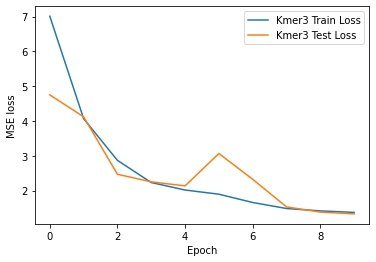

In [20]:
h1 = 10
h2 = 10
train_dl,test_dl = dls['multi_kmer_3']

num_kmers = len(train_dl.dataset.kmers)

kmer_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer_lin_model.parameters(), lr=0.01) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer_lin_data_label = list(zip([train_losses,val_losses], ['Kmer3 Train Loss','Kmer3 Test Loss']))
u.quick_loss_plot(kmer_lin_data_label)

In [21]:
# check out model??
kmer_lin_model

Kmer_Linear_Multi(
  (lin_share): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU(inplace=True)
  )
  (obj0): Linear(in_features=10, out_features=1, bias=True)
  (obj1): Linear(in_features=10, out_features=1, bias=True)
  (obj2): Linear(in_features=10, out_features=1, bias=True)
)

In [22]:
lin = kmer_lin_model.lin_share[0]
w = lin.weight
x = sum(w)

xdf = pd.DataFrame(list(zip(train_dl.dataset.kmers, [y.item() for y in x])), columns=['mer','w'])
xdf.sort_values('w').tail(30)

,mer,w
15,ATT,-0.193306
45,GTC,-0.184445
57,TGC,-0.091500
31,CTT,-0.069580
28,CTA,-0.063453
25,CGC,-0.056502
16,CAA,-0.043547
22,CCG,-0.039622
17,CAC,-0.014355
12,ATA,0.066091


### k=1

Epoch: 0
0 5.376708970406014
Epoch: 1
1 5.406494351396628
Epoch: 2
2 5.27069577953966
Epoch: 3
3 5.143513553492499
Epoch: 4
4 5.3314880178147135
Epoch: 5
5 5.2495309872200915
Epoch: 6
6 5.138131643454767
Epoch: 7
7 5.163385211530167
Epoch: 8
8 5.150405073878894
Epoch: 9
9 5.12137492582643


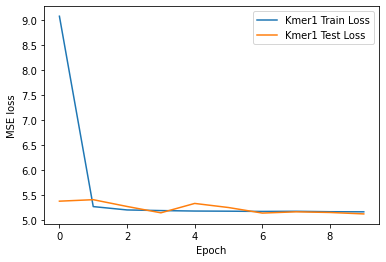

In [23]:
train_dl,test_dl = dls['multi_kmer_1']

num_kmers = len(train_dl.dataset.kmers)

kmer1_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer1_lin_model.parameters(), lr=0.01) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer1_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer1_lin_data_label = list(zip([train_losses,val_losses], ['Kmer1 Train Loss','Kmer1 Test Loss']))
u.quick_loss_plot(kmer1_lin_data_label)

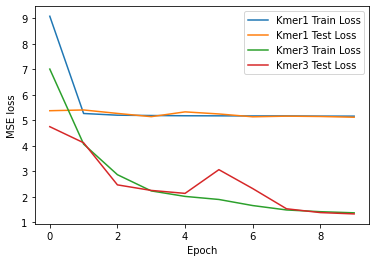

In [24]:
u.quick_loss_plot(kmer1_lin_data_label+kmer_lin_data_label)

### k=6

In [25]:
# train_dl,test_dl = dls['multi_kmer_6']

# num_kmers = len(train_dl.dataset.kmers)

# kmer6_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

# loss_func = torch.nn.MSELoss() 
# optimizer = torch.optim.SGD(kmer6_lin_model.parameters(), lr=0.001) 

# epochs = 10
# train_losses, val_losses = fit(epochs, kmer6_lin_model, loss_func, optimizer, train_dl, test_dl)

# kmer6_lin_data_label = list(zip([train_losses,val_losses], ['Kmer6 Train Loss','Kmer6 Test Loss']))
# u.quick_loss_plot(kmer6_lin_data_label)

In [26]:
#u.quick_loss_plot(kmer1_lin_data_label+kmer_lin_data_label+kmer6_lin_data_label)

## try linear OHE model

In [27]:
h1 = 10
h2 = 10
seq_len = len(train_df['seq'][0])
seq_len

8

Epoch: 0
0 4.706199988236251
Epoch: 1
1 4.364067911847102
Epoch: 2
2 4.179813068524926
Epoch: 3
3 4.165641334022659
Epoch: 4
4 3.789319392635868
Epoch: 5
5 4.926739361070081
Epoch: 6
6 3.634647078509734
Epoch: 7
7 4.379633743151099
Epoch: 8
8 3.4046316695424306
Epoch: 9
9 3.272252032769174


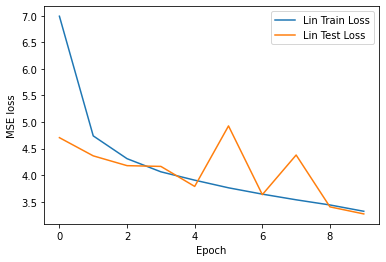

In [28]:
multi_lin_model = DNA_Linear_Multi(seq_len, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.01) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses, val_losses = fit(epochs, multi_lin_model, loss_func, optimizer, train_dl, test_dl)

multi_lin_data_label = list(zip([train_losses,val_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(multi_lin_data_label)

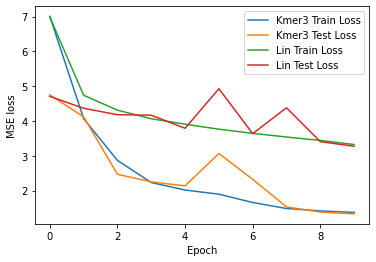

In [29]:
u.quick_loss_plot(kmer_lin_data_label + multi_lin_data_label)

In [30]:
def quick_seq_pred_multi(model, seqs,dss,oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        if dss.name == "multi_ohe":
            s = torch.tensor(u.one_hot_encode(dna))
        elif dss.name == "multi_kmer":
            s = torch.tensor(count_kmers_in_seq(dna,kmers(dss.k)))
        else:
            raise ValueError(f"Unknown DataSetSpec Type {dss.name}. Currently just [multi_ohe,multi_kmer]")
        pred = [x.item() for x in model(s.float())]
        actual = oracle[dna]
        diff = [actual[i]-pred[i] for i in range(len(pred))]
        print(f"{dna}: \n \tpred:{pred[0]:.3f} act:{actual[0]:.3f} ({diff[0]:.3f}) \n\tpred:{pred[1]:.3f} act:{actual[1]:.3f} ({diff[1]:.3f}) \n\tpred:{pred[2]:.3f} act:{actual[2]:.3f} ({diff[2]:.3f})")
        

def quick_test8(model,dss,oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred_multi(model, seqs,dss,oracle)
        print()

In [31]:
multi_8mer_oracle = dict([(x,[a,b,c]) for (x,a,b,c) in multi_df[['seq','mode0','mode1','mode2']].values])

In [32]:
multi_8mer_oracle['AAAAGGAA']

[18.5, 8.5, 18.5]

In [33]:
dataset_types

In [34]:
quick_test8(multi_lin_model,DatasetSpec('multi_ohe'),multi_8mer_oracle)

AAAAAAAA: 
 	pred:20.264 act:20.000 (-0.264) 
	pred:20.581 act:20.000 (-0.581) 
	pred:20.562 act:20.000 (-0.562)
CCCCCCCC: 
 	pred:17.250 act:17.000 (-0.250) 
	pred:17.390 act:17.000 (-0.390) 
	pred:17.952 act:17.000 (-0.952)
GGGGGGGG: 
 	pred:14.222 act:14.000 (-0.222) 
	pred:14.636 act:14.000 (-0.636) 
	pred:14.106 act:14.000 (-0.106)
TTTTTTTT: 
 	pred:12.354 act:11.000 (-1.354) 
	pred:12.453 act:11.000 (-1.453) 
	pred:13.095 act:11.000 (-2.095)

AACCAACA: 
 	pred:19.165 act:18.875 (-0.290) 
	pred:19.399 act:18.875 (-0.524) 
	pred:17.777 act:18.875 (1.098)
CCGGCGCG: 
 	pred:15.069 act:15.500 (0.431) 
	pred:15.199 act:15.500 (0.301) 
	pred:15.329 act:15.500 (0.171)
GGGTAAGG: 
 	pred:15.078 act:15.125 (0.047) 
	pred:13.922 act:15.125 (1.203) 
	pred:16.114 act:15.125 (-0.989)
TTTCGTTT: 
 	pred:12.548 act:12.125 (-0.423) 
	pred:12.971 act:12.125 (-0.846) 
	pred:12.510 act:12.125 (-0.385)
TGTAATAC: 
 	pred:15.530 act:15.500 (-0.030) 
	pred:15.749 act:15.500 (-0.249) 
	pred:16.244 act:15.5

In [35]:
quick_test8(kmer_lin_model,DatasetSpec('multi_kmer',k=3),multi_8mer_oracle)

AAAAAAAA: 
 	pred:17.007 act:20.000 (2.993) 
	pred:16.891 act:20.000 (3.109) 
	pred:17.120 act:20.000 (2.880)
CCCCCCCC: 
 	pred:15.783 act:17.000 (1.217) 
	pred:16.110 act:17.000 (0.890) 
	pred:16.086 act:17.000 (0.914)
GGGGGGGG: 
 	pred:14.707 act:14.000 (-0.707) 
	pred:14.705 act:14.000 (-0.705) 
	pred:14.942 act:14.000 (-0.942)
TTTTTTTT: 
 	pred:13.684 act:11.000 (-2.684) 
	pred:13.953 act:11.000 (-2.953) 
	pred:13.805 act:11.000 (-2.805)

AACCAACA: 
 	pred:18.441 act:18.875 (0.434) 
	pred:18.448 act:18.875 (0.427) 
	pred:18.280 act:18.875 (0.595)
CCGGCGCG: 
 	pred:15.413 act:15.500 (0.087) 
	pred:15.667 act:15.500 (-0.167) 
	pred:16.214 act:15.500 (-0.714)
GGGTAAGG: 
 	pred:15.524 act:15.125 (-0.399) 
	pred:7.493 act:15.125 (7.632) 
	pred:14.810 act:15.125 (0.315)
TTTCGTTT: 
 	pred:12.615 act:12.125 (-0.490) 
	pred:12.393 act:12.125 (-0.268) 
	pred:13.592 act:12.125 (-1.467)
TGTAATAC: 
 	pred:15.456 act:15.500 (0.044) 
	pred:15.862 act:15.500 (-0.362) 
	pred:15.098 act:15.500 (0.40

### Try CNN??

In [36]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3,
                 lin_share_size=10
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_share = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), lin_share_size),
            nn.ReLU(inplace=True),
        ) 
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(lin_share_size,1)
        self.obj1  = nn.Linear(lin_share_size,1)
        self.obj2  = nn.Linear(lin_share_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        
        out = self.conv_share(xb)
        
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
        # ^^ where does this go and what does it do?

Epoch: 0
0 4.275617622186907
Epoch: 1
1 3.77205020507589
Epoch: 2
2 3.4416501578085663
Epoch: 3
3 4.012505079647154
Epoch: 4
4 2.7069641030485907
Epoch: 5
5 2.563293670822216
Epoch: 6
6 2.032282089746904
Epoch: 7
7 1.9329910178645777
Epoch: 8
8 1.5783225743371174
Epoch: 9
9 1.6682768350408541


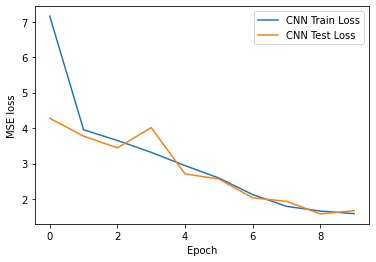

In [37]:
seq_len = len(train_df['seq'][0])
multi_cnn_model = DNA_CNN_Multi(seq_len)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_cnn_model.parameters(), lr=0.01) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses_cnn, val_losses_cnn = fit(epochs, multi_cnn_model, loss_func, optimizer, train_dl, test_dl)

multi_cnn_data_label = list(zip([train_losses_cnn,val_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(multi_cnn_data_label)

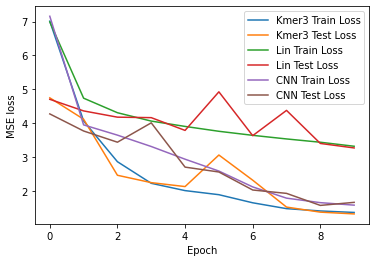

In [38]:
u.quick_loss_plot(kmer_lin_data_label + multi_lin_data_label + multi_cnn_data_label)

In [39]:
quick_test8(multi_cnn_model, DatasetSpec('multi_ohe'), multi_8mer_oracle)

AAAAAAAA: 
 	pred:19.598 act:20.000 (0.402) 
	pred:20.499 act:20.000 (-0.499) 
	pred:21.220 act:20.000 (-1.220)
CCCCCCCC: 
 	pred:17.319 act:17.000 (-0.319) 
	pred:16.889 act:17.000 (0.111) 
	pred:18.683 act:17.000 (-1.683)
GGGGGGGG: 
 	pred:14.240 act:14.000 (-0.240) 
	pred:14.009 act:14.000 (-0.009) 
	pred:14.400 act:14.000 (-0.400)
TTTTTTTT: 
 	pred:11.425 act:11.000 (-0.425) 
	pred:10.746 act:11.000 (0.254) 
	pred:10.825 act:11.000 (0.175)

AACCAACA: 
 	pred:19.200 act:18.875 (-0.325) 
	pred:18.511 act:18.875 (0.364) 
	pred:20.604 act:18.875 (-1.729)
CCGGCGCG: 
 	pred:15.533 act:15.500 (-0.033) 
	pred:15.026 act:15.500 (0.474) 
	pred:12.737 act:15.500 (2.763)
GGGTAAGG: 
 	pred:15.305 act:15.125 (-0.180) 
	pred:14.089 act:15.125 (1.036) 
	pred:15.038 act:15.125 (0.087)
TTTCGTTT: 
 	pred:12.518 act:12.125 (-0.393) 
	pred:12.114 act:12.125 (0.011) 
	pred:11.843 act:12.125 (0.282)
TGTAATAC: 
 	pred:15.383 act:15.500 (0.117) 
	pred:15.688 act:15.500 (-0.188) 
	pred:15.100 act:15.500 (0.

In [40]:
def alt_parity_plot_multi(model,df, pearson,task):
    chart = alt.Chart(df).mark_circle(opacity=0.2).encode(
        alt.X('pred:Q'),
        alt.Y('truth:Q'),
        alt.Color('mode:N'),
        tooltip=['seq:N']
    ).properties(
        title=f'Model (pearson:{pearson})'
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{task}_{model}.html')
    
def parity_plot_multi(model,df, pearson):
    #plt.scatter(df['pred'].values, df['truth'].values, alpha=0.2)
    sns.scatterplot(data=df,x='pred',y='truth',hue='mode',alpha=0.2)
    plt.xlabel("Predicted Score",fontsize=14)
    plt.ylabel("Actual Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()

def parity_pred_multi(models, seqs, oracle,task,alt=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model,dss in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            if dss.name == "multi_ohe":
                s = torch.tensor(u.one_hot_encode(dna))
            elif dss.name == "multi_kmer":
                s = torch.tensor(count_kmers_in_seq(dna,kmers(dss.k)))
            else:
                raise ValueError(f"Unknown DataSetSpec Type {dss.name}. Currently just [multi_ohe,multi_kmer]")
        
            #s = torch.tensor(u.one_hot_encode(dna))
            actual = oracle[dna]
            pred = [x.item() for x in model(s.float())]
            
            
            # loop through each prediction task
            for i in range(len(actual)):
                actual_i = actual[i]
                pred_i = pred[i]
                mode = f'mode{i}'
                data.append([dna,actual_i,pred_i,mode])
                
        df = pd.DataFrame(data, columns=['seq','truth','pred','mode'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot_multi(model_name, df, pearson,task)
            
        parity_plot_multi(model_name, df, pearson)

    return dfs

In [41]:
import seaborn as sns
import altair as alt

Running Multi_Linear_8mer


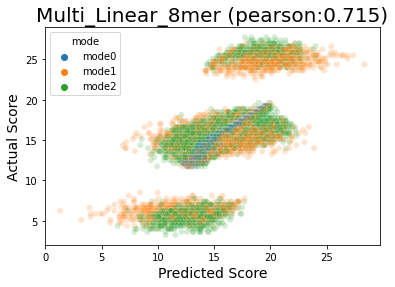

Running Multi_Kmer_8mer


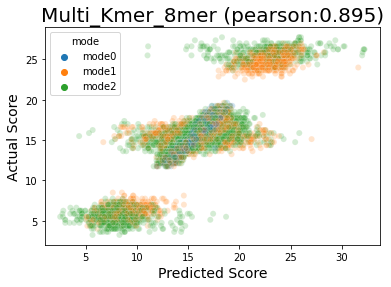

Running Multi_CNN_8mer


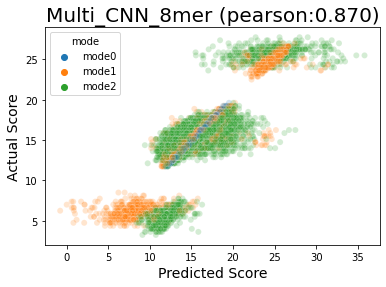

In [42]:
models = [
    ("Multi_Linear_8mer",multi_lin_model,DatasetSpec('multi_ohe')),
    ("Multi_Kmer_8mer",kmer_lin_model,DatasetSpec('multi_kmer',k=3)),
    ("Multi_CNN_8mer",multi_cnn_model,DatasetSpec('multi_ohe')),
]

seqs = test_df['seq'].values
task = "8mer_multitask_orderedMotifs"

dfs = parity_pred_multi(models, seqs, multi_8mer_oracle,task,alt=True)

# inspect

### cnn model

In [43]:
multi_cnn_model

DNA_CNN_Multi(
  (conv_share): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=192, out_features=10, bias=True)
    (4): ReLU(inplace=True)
  )
  (obj0): Linear(in_features=10, out_features=1, bias=True)
  (obj1): Linear(in_features=10, out_features=1, bias=True)
  (obj2): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(multi_cnn_model)

Total convolutional layers: 1


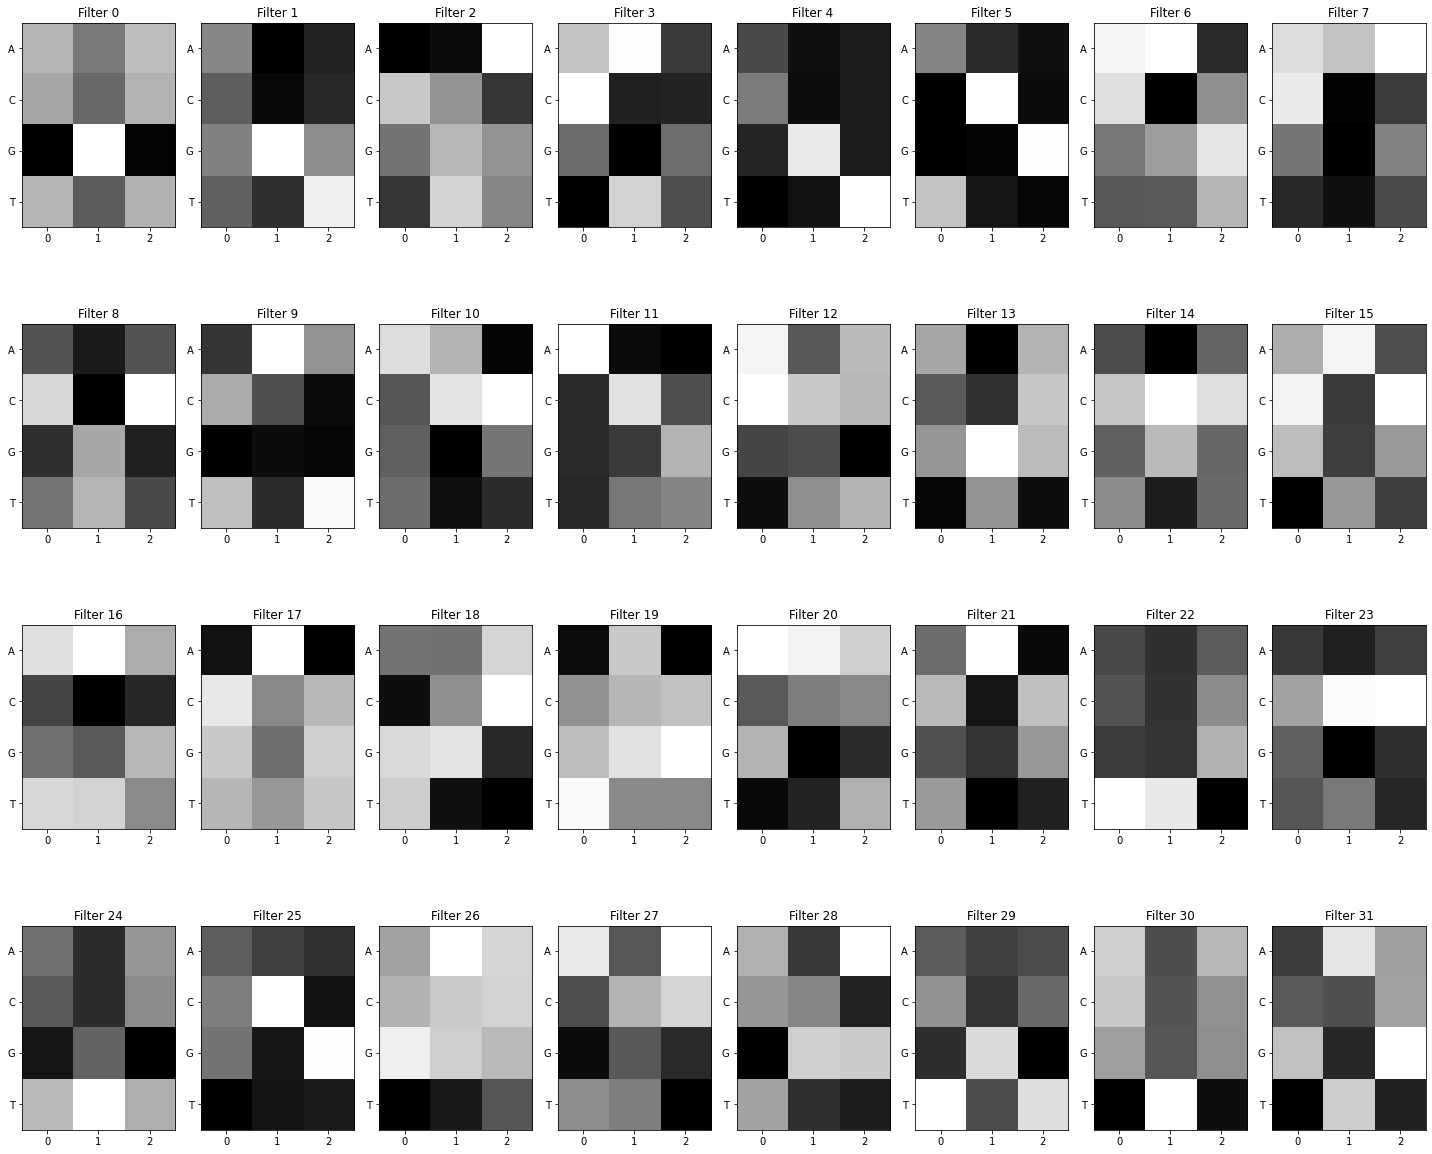

In [45]:
u.view_filters(model_weights)

In [46]:
seqs8_5k = u.downselect_list(seqs8,5000)
filter_activations = u.get_filter_activations(seqs8_5k, conv_layers[0])

Running seq ACCCGGAG
Running seq GGTTGCCA
Running seq CGAGCGTG
Running seq CTAGGCCG
Running seq CCGTCATC
Running seq CGCGGGTT
Running seq CGTGCAGA
Running seq GATCTCAC
Running seq AGCTGATC
Running seq CGTTCCGG
Running seq TCAGGATG
Running seq GGTCATCT
Running seq AGTCAGAT
Running seq TACCGACG
Running seq AGTGGATG
Running seq AGGTAATC
Running seq TATCATGG
Running seq AAATAACT
Running seq AAGGGGGG
Running seq AGTGTATG
Running seq CCATTTAC
Running seq CTTAAAGT
Running seq TGTGCCCT
Running seq CCAGCCTC
Running seq GCAGCATT
Running seq CTATTTAG
Running seq GCGGCTGA
Running seq TTTCATGA
Running seq CAGTCCGT
Running seq CCGCTAGC
Running seq ACCCTACT
Running seq AAGGCCCA
Running seq GTGTCGGG
Running seq AATCATTA
Running seq ATTTGGGT
Running seq AGCCGTTA
Running seq GACCGAGA
Running seq CAAACGCA
Running seq GGTAAGGA
Running seq ATGTGCTA
Running seq TATTATGT
Running seq GAAGATGG
Running seq TTGAAGTC
Running seq GTAAAGCT
Running seq ATACTGGG
Running seq AGTGTAAA
Running seq CCTGTGCC
Running seq A

Running seq ATCACCCC
Running seq CATTGGTC
Running seq TGGTTTTG
Running seq ACGATGCA
Running seq ACTCATGG
Running seq CCCGTACA
Running seq TAACGTCT
Running seq CGATTGAT
Running seq TCGTACTA
Running seq ATATCCAG
Running seq GCGTCCAC
Running seq GGATGCCA
Running seq ATGTACAA
Running seq CAGGTCGG
Running seq TGGTCACC
Running seq TTTACGTT
Running seq AGCTATGC
Running seq TATTCGTT
Running seq GTGCCCTT
Running seq TCGGGTGT
Running seq CGGTCCAT
Running seq AGTCCGGG
Running seq GGTAGCCC
Running seq ACCACGTA
Running seq AAAGTCTC
Running seq GTAACCCA
Running seq TTTGTGCG
Running seq ATGCTATT
Running seq GTCTCCAC
Running seq GGCGCATC
Running seq TCACGGGA
Running seq ACATATCC
Running seq CACGGGGT
Running seq TCTTGGCG
Running seq ACTATAAA
Running seq GTGGCACG
Running seq GTAATTAA
Running seq CCTGTCAG
Running seq CCCATTTA
Running seq CACTCGTC
Running seq CGAGCCCA
Running seq CTAGGCGA
Running seq CGATACCC
Running seq TCAAACCA
Running seq GGCAGGTC
Running seq AAATCGGG
Running seq ACACGCGT
Running seq C

Running seq TCGCGCCT
Running seq ACTTTACT
Running seq CCCGGGGT
Running seq AGAGTGTC
Running seq TAACTGGA
Running seq GAGGTGCT
Running seq TACGAAAT
Running seq CTGTGTTG
Running seq TCGAAGTT
Running seq AAACTACG
Running seq TGAGCCAG
Running seq TCGTCTCA
Running seq CATTGCTA
Running seq CCAATATA
Running seq CTACGTCA
Running seq TTTCCGTG
Running seq GGAGGAAA
Running seq GGGACGTT
Running seq TATATCCT
Running seq AATTAGCT
Running seq GTGGATAA
Running seq CACACACT
Running seq AATGGATG
Running seq GACGTATT
Running seq CGCTTGGC
Running seq ATCGAGCT
Running seq GCTTAAGG
Running seq GGCTACTG
Running seq ACCTATCA
Running seq CTATAGGG
Running seq GTTCTCAT
Running seq CATACTAG
Running seq CCCCTGTA
Running seq GCCTCCAT
Running seq CGGACCCA
Running seq GTACAAGA
Running seq CCGTTCCG
Running seq CAGTGTAG
Running seq GCCTGTCG
Running seq TCCAAGAA
Running seq GCTCACAA
Running seq TCAACCTT
Running seq GCAGTTGA
Running seq TTTTACTC
Running seq GTTGGAAA
Running seq GACACTTC
Running seq CGTGAAAC
Running seq G

Running seq AGTGTAGT
Running seq ACATCGTT
Running seq GGGTAGGG
Running seq TGCGATCT
Running seq TCCCCCCA
Running seq AGGCTGTA
Running seq CCGAAGGT
Running seq TTTCCATG
Running seq GAACCTTC
Running seq TAGCTACC
Running seq TATCCCTC
Running seq GAGCCACG
Running seq GGATTGGT
Running seq CTGCGAAG
Running seq GCCCTAGT
Running seq ACGACTCC
Running seq GACATACC
Running seq ACTTAACG
Running seq GTCCCATA
Running seq GCAATCTC
Running seq TCCAGCCC
Running seq GGGCGGAC
Running seq TCGTAAGT
Running seq TGGTAAAG
Running seq ACTAAGCA
Running seq TAATCTAC
Running seq AGGAACCT
Running seq CTAAGACG
Running seq CCAGGGGC
Running seq CATTGGTA
Running seq GGACCTCT
Running seq CACGACCT
Running seq CCCATGAA
Running seq CTTAATTG
Running seq CTCAGCCT
Running seq CACGTTCC
Running seq CCTGGCCG
Running seq TCAACCCA
Running seq ACGGAAAC
Running seq CAACATGA
Running seq TGGTGCCA
Running seq ATACATGA
Running seq TAATCGAT
Running seq AGAAGAGA
Running seq TGGAACTG
Running seq TATTCGCG
Running seq ATTCCAAT
Running seq C

Running seq AGTGCGGA
Running seq CAAGAAAA
Running seq ACTTTGGT
Running seq GTGGAGGA
Running seq TTAGAAGT
Running seq AGTAGAGC
Running seq GCAAGAGC
Running seq GGACGGAC
Running seq CGGGTCAG
Running seq CGGCGTAG
Running seq TGAGAAAG
Running seq TTATAGCA
Running seq AGAGACAA
Running seq TGGCAACA
Running seq ATCTGACG
Running seq TATCCTTA
Running seq GGGGTGTG
Running seq TCTCTGCG
Running seq CAAAGCGT
Running seq TCAGTGGT
Running seq TCCCCCTA
Running seq CATGGTTG
Running seq AGCCCCAA
Running seq CGATCCAA
Running seq AGTACGAG
Running seq TTAGTGTA
Running seq CTGCGTGC
Running seq CCTCCGAA
Running seq GTTATGTG
Running seq CTTATCTG
Running seq AGCATTCT
Running seq CAATGGCT
Running seq AGGTCATT
Running seq GGAAAGCA
Running seq AACGGGGG
Running seq TGCTGGGA
Running seq CCTATCTG
Running seq ACCGTACT
Running seq CCAATTAG
Running seq CGCTCGCT
Running seq ATATGCAA
Running seq GCGATATA
Running seq GTGACGGA
Running seq GAAAGGTG
Running seq TCGGCAAT
Running seq GTTAGCTT
Running seq CGCCTGTA
Running seq C

Running seq TGCATGGA
Running seq TTACGGTG
Running seq TGGCCATA
Running seq GTCACTCA
Running seq TCTTGAAG
Running seq TTTCTGAC
Running seq GTCGACAC
Running seq TACGATTC
Running seq CCTGGGCA
Running seq CAAATCAG
Running seq TTACTAGG
Running seq TCATGCGT
Running seq ACCGGACA
Running seq GAGGTTAA
Running seq AAATGATA
Running seq TCGTGAAT
Running seq TTGTTCCC
Running seq AGGACATA
Running seq TAGCGCGG
Running seq GTTTTTTA
Running seq ATCGTTCC
Running seq TCCCTTTA
Running seq TATAAGAA
Running seq CTCAGCGG
Running seq GGTATCTA
Running seq TCAGAGCG
Running seq TTACACCT
Running seq GCTCCCCA
Running seq CCACATAG
Running seq CAACCTGG
Running seq GGCCCTGT
Running seq CGAATCTT
Running seq ACTCGCCA
Running seq CTTGAAAT
Running seq CCCGACAT
Running seq CCTCGTAG
Running seq AACTAGAA
Running seq TCCCCGGG
Running seq TGAGGGAA
Running seq CGCTACAA
Running seq ACCCCTCC
Running seq CATAAGTT
Running seq ACTAACAG
Running seq AGAACCGA
Running seq GCGATCAG
Running seq GGACCCTC
Running seq TGACCCCA
Running seq G

Running seq TGTCAGCG
Running seq CGTTCTAT
Running seq CTACATGC
Running seq ACTGTGAG
Running seq TGCCGCCT
Running seq ATCATTCT
Running seq GGATAATG
Running seq GCACAGCC
Running seq CACGCAAA
Running seq CGACGCAA
Running seq AAGAATTC
Running seq CATTCTCA
Running seq GCTAGCTG
Running seq TTGCCAGG
Running seq TCGCCATG
Running seq AGTAATCA
Running seq GTTTGGTA
Running seq GCAGAATC
Running seq TTTCGGGC
Running seq CTCGACAC
Running seq CAGGTGCG
Running seq GGATAGAC
Running seq TAAGGATT
Running seq TCGCTCTA
Running seq GCAAAATG
Running seq AATGGTGG
Running seq CACTCTAC
Running seq AGCGGAAA
Running seq CCGACAAC
Running seq TCGGTTAC
Running seq ACAGGTTA
Running seq TTCGGGAA
Running seq TTTCCTGC
Running seq GAACAATG
Running seq GTGAATCG
Running seq TGCGGGGA
Running seq GTCTGCGT
Running seq GGATTCTA
Running seq ATCGTATA
Running seq CCTGCCCC
Running seq CGACCGCT
Running seq TTACTGGG
Running seq TATTGAGC
Running seq ATCCGCCA
Running seq ACCGATCA
Running seq GGGGTTCT
Running seq TAGTTCGG
Running seq T

Running seq TCTTGTAG
Running seq CGGCAACC
Running seq CTCTACTT
Running seq ACGGCGGG
Running seq AAGCCTCA
Running seq TTTTACGT
Running seq ACGCACCT
Running seq CTCTGTGT
Running seq CGAGGTCC
Running seq ACCTCTAG
Running seq ATGGAATA
Running seq TGACCACC
Running seq GAAAAACT
Running seq TCAACATT
Running seq CTTTTTCC
Running seq TCACTGCG
Running seq AGTGGAGC
Running seq CAGTGAGA
Running seq GGAGTCGA
Running seq CGGTTGCG
Running seq GTGAAATC
Running seq GTTACCAG
Running seq TTCGGGGT
Running seq TGGGTAAG
Running seq CCACATGG
Running seq TAAGGGAC
Running seq GACATAAT
Running seq TTACGAGT
Running seq ACTATAAC
Running seq TGTGCGCA
Running seq ATGAAGGT
Running seq TCGAAACC
Running seq ATGTGCCG
Running seq ACTAAAAA
Running seq TATCATTC
Running seq CAGTCAAC
Running seq TCTCGGCT
Running seq ACCTTGAA
Running seq CGGACGTA
Running seq AACGTTCG
Running seq CTGACACA
Running seq CGCTAGGC
Running seq GCTCTCAC
Running seq CCGACACC
Running seq TATCTCTA
Running seq ATGGGTAA
Running seq AGGCGAGC
Running seq G

Running seq GCGCCTGA
Running seq GGCCTGGG
Running seq ATCTCATA
Running seq TAGCGTTG
Running seq CTAAAAGG
Running seq ACGGCAAT
Running seq TGGAAGTC
Running seq CCTTTGAC
Running seq ACGTAGCG
Running seq GGGGTCTA
Running seq CTAACCTC
Running seq AGAGTTGG
Running seq TGCTTCTG
Running seq CTGCTTGA
Running seq AAATATCG
Running seq AACAGTCG
Running seq TTCCGACG
Running seq GAAAAGAA
Running seq TGTTGAAT
Running seq GTAGGAGA
Running seq ACAACCGG
Running seq TCGAAGTC
Running seq AGAGACAG
Running seq CATACTCG
Running seq CCCGTGCC
Running seq GACGGGCG
Running seq CATCCTAA
Running seq CATTAAGT
Running seq AATTGCTG
Running seq TCAAGATA
Running seq AATCAGTT
Running seq ACGTACCG
Running seq CAACTAGG
Running seq ATTATCCC
Running seq CCATGGAT
Running seq GTAACACC
Running seq AGAAAGTG
Running seq AGGAGACT
Running seq CGTGGGCA
Running seq AGAGACTA
Running seq CTAGCTAA
Running seq GGGGCTCC
Running seq ATGAGAGA
Running seq TGGCGCCC
Running seq CTACACAT
Running seq CGCACTTC
Running seq ACTAAAAT
Running seq C

Running seq GAATAGCT
Running seq ATGCGTGA
Running seq ACATACGT
Running seq GCTGGAGT
Running seq TATTTGTC
Running seq AAGGGGGT
Running seq AGGCTGGT
Running seq TAGCGGCA
Running seq AAGGAGAC
Running seq TTAGATCG
Running seq TACAAACA
Running seq TATGTGGT
Running seq AATTTAAA
Running seq GAGTGACG
Running seq ATTGCACG
Running seq GCTCTGTC
Running seq ATGTCCAG
Running seq GAAACCGC
Running seq GTAAAGGG
Running seq CTGCTTTC
Running seq CTCAGCCC
Running seq GTAGTATG
Running seq AAATCTTT
Running seq GGGATCTA
Running seq CTCAGGAA
Running seq ACTTGGAT
Running seq AGAAGGCC
Running seq GACGTTAC
Running seq GCTCGTAA
Running seq ATCTAACC
Running seq ACGCAACG
Running seq CAATTTGG
Running seq TCTCGGTC
Running seq GTTAAGAG
Running seq CCACAAGA
Running seq TCTGTGAC
Running seq GATATGCA
Running seq GGCCCTGA
Running seq CCCTAAAA
Running seq ATCAGACT
Running seq AACTAGGA
Running seq CGAAGAAA
Running seq CTCCCGTA
Running seq CGGAGTGC
Running seq AGCGAGTT
Running seq AACTCGAG
Running seq CGGGCGGG
Running seq A

Running seq CAGATAAG
Running seq CCATCCTC
Running seq TACGGTCC
Running seq AGGGCAGG
Running seq ATTCGTGA
Running seq CACGACAC
Running seq AATATCGC
Running seq TCATGATT
Running seq GCGCAGGT
Running seq GACGTCCC
Running seq GGCCCGTT
Running seq AACTCTGC
Running seq CGCTCGAG
Running seq CTGGACAA
Running seq CTACGATG
Running seq CACCTTAA
Running seq AGGCCCAA
Running seq AGCGTAGG
Running seq GAGCGACG
Running seq GGTACGAG
Running seq TAGCGAAA
Running seq CGATTACA
Running seq AGTGAATC
Running seq TGTCAATT
Running seq AGCGTACG
Running seq TGGACCTT
Running seq TCTTCTCG
Running seq CAGCTCTT
Running seq GGGAGATT
Running seq ATATTTAC
Running seq GTCGTACT
Running seq CGCTTCAG
Running seq GGTACATC
Running seq GCATTTGC
Running seq TTAGTTCG
Running seq AACCTTGC
Running seq CCCACGCC
Running seq AAGCTATC
Running seq ATTGGATA
Running seq GTGGTTCA
Running seq CAGTTTTT
Running seq TCGGTTCA
Running seq AATAAAAC
Running seq CGTTGATA
Running seq GGGCCCTC
Running seq GCACATCT
Running seq TTGATATA
Running seq G

Running seq AATGTGAG
Running seq TCTCCGGC
Running seq ACCAATTT
Running seq CGAGATAC
Running seq GCGCGCTG
Running seq ATGATTCG
Running seq GTGCGGAC
Running seq AAAGGTTT
Running seq AGTGTCAG
Running seq AATCGCAC
Running seq TGTTCGGA
Running seq CTTTCAGG
Running seq GTGCTGGT
Running seq TGTGAGAA
Running seq ATGAACGC
Running seq CCTGAAAA
Running seq GAAACGTT
Running seq GGAGGAGG
Running seq TGGGCCCT
Running seq CCTATTTT
Running seq TAATACAG
Running seq TCATCGAC
Running seq CAGGAATT
Running seq AGCAGCTG
Running seq TGTCTACG
Running seq AATCTATG
Running seq AGGGATGG
Running seq TGAAGACT
Running seq ACATCTAG
Running seq GTCGCGAT
Running seq TGGTGCCC
Running seq GGGCTGCT
Running seq GTGCACTA
Running seq TCAGGCTC
Running seq GGCACCGT
Running seq CGCGCCCT
Running seq TTCCAATG
Running seq AACCTTTG
Running seq AGATCTTG
Running seq CATTGTCA
Running seq GCCTCCTT
Running seq TCAAAGGA
Running seq CAATAGAT
Running seq ATGAAGTG
Running seq AAGTGCTG
Running seq TCGTCCGC
Running seq GGCCGGCA
Running seq C

Running seq CGGATCCA
Running seq TAATGTCG
Running seq CTCCTCAC
Running seq ACTTCGTC
Running seq GCGCTTAA
Running seq GCACCTAA
Running seq TAAACCGC
Running seq ACCCAACG
Running seq AACAGGGT
Running seq CAGTCGTA
Running seq GGACAGTT
Running seq ACAATGCT
Running seq GTTAACCA
Running seq GTGGCAAG
Running seq AAAGCCCA
Running seq ACTACCAC
Running seq ACGGGGAC
Running seq CCTACCGA
Running seq CAGAACTG
Running seq GTATTATG
Running seq GTAAATAC
Running seq GCCACGCC
Running seq CAAGAGAG
Running seq TCTTGGGG
Running seq TGGGCCTA
Running seq CGCATATC
Running seq GGGACCTT
Running seq GACAGACC
Running seq TGGACAAA
Running seq TGTCCTCG
Running seq AATGGGTG
Running seq AGCAGTAC
Running seq GCAAATCA
Running seq ATACCTAG
Running seq TAGGCTTC
Running seq AAGCCGGA
Running seq TAGCTGCA
Running seq GTCGACTG
Running seq CAGAGCTA
Running seq ACTTTCGC
Running seq TGCTAGCT
Running seq CAGAAACC
Running seq CAGCTGAG
Running seq TACGGGTT
Running seq GTAGAATA
Running seq ATCCTCCA
Running seq AGCTCAGC
Running seq G

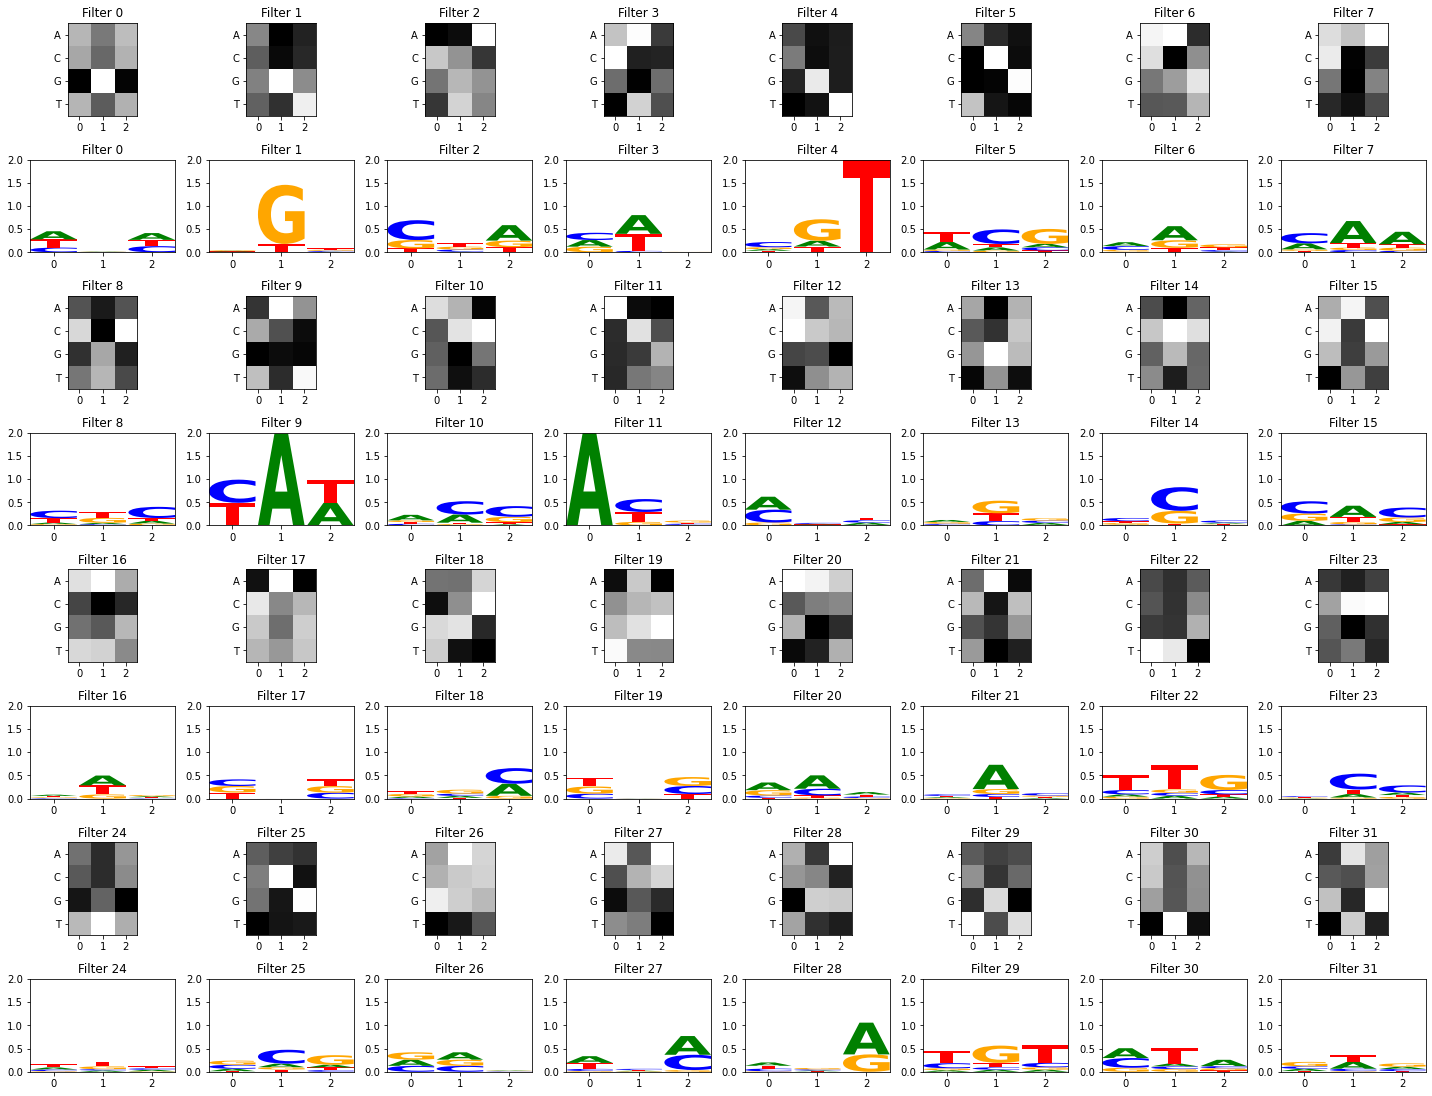

In [47]:
u.view_filters_and_logos(model_weights,filter_activations)

# Try LSTM multi

In [48]:
class DNA_LSTM_Multi(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        #self.fc = nn.Linear(hidden_dim, 1)
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(hidden_dim,1)
        self.obj1  = nn.Linear(hidden_dim,1)
        self.obj2  = nn.Linear(hidden_dim,1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
                        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?

        out0 = self.obj0(last_layer)
        out1 = self.obj1(last_layer)
        out2 = self.obj2(last_layer)
        
        if verbose:
            print("last layer:", last_layer.shape)
            print("LSTM->FC out shape:",out0.shape)   
                                                
        return out0,out1,out2

Epoch: 0
0 5.335219767495994
Epoch: 1
1 4.902338805488235
Epoch: 2
2 4.860160475501863
Epoch: 3
3 4.9312583863971655
Epoch: 4
4 4.737148855166861
Epoch: 5
5 4.722423686317675
Epoch: 6
6 4.557572590420804
Epoch: 7
7 4.360319553878128
Epoch: 8
8 4.123867208069332
Epoch: 9
9 4.209513539252282


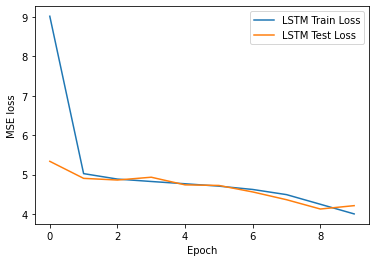

In [49]:
seq_len = len(train_df['seq'][0])
multi_lstm_model = DNA_LSTM_Multi(seq_len)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lstm_model.parameters(), lr=0.01) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses_lstm, val_losses_lstm = fit(epochs, multi_lstm_model, loss_func, optimizer, train_dl, test_dl)

multi_lstm_data_label = list(zip([train_losses_lstm,val_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(multi_lstm_data_label)

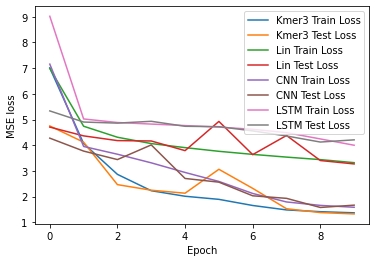

In [50]:
u.quick_loss_plot(
    kmer_lin_data_label + \
    multi_lin_data_label + \
    multi_cnn_data_label + \
    multi_lstm_data_label
)

Running Multi_Linear_8mer


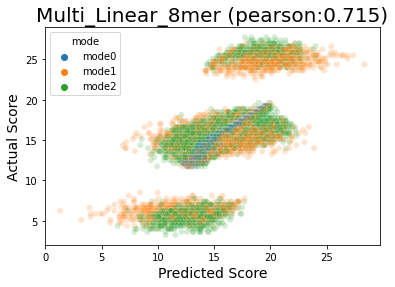

Running Multi_Kmer_8mer


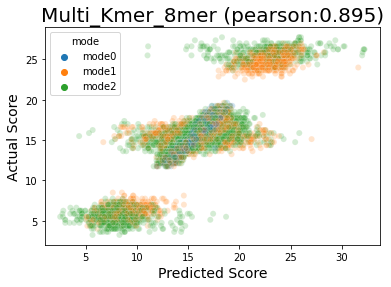

Running Multi_CNN_8mer


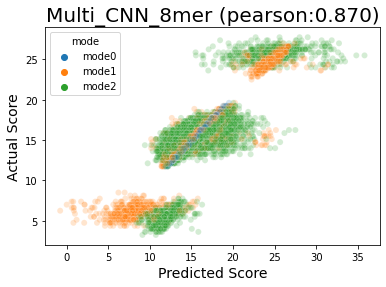

Running Multi_LSTM_8mer


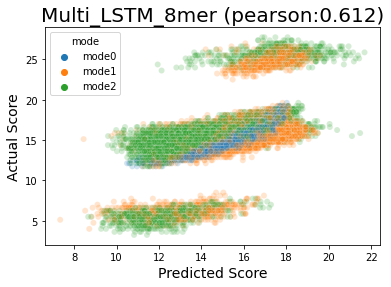

In [51]:
models = [
    ("Multi_Linear_8mer",multi_lin_model,DatasetSpec('multi_ohe')),
    ("Multi_Kmer_8mer",kmer_lin_model,DatasetSpec('multi_kmer',k=3)),
    ("Multi_CNN_8mer",multi_cnn_model,DatasetSpec('multi_ohe')),
    ("Multi_LSTM_8mer",multi_lstm_model,DatasetSpec('multi_ohe')),
]

seqs = test_df['seq'].values
task = "8mer_multitask_orderedMotifs"

dfs = parity_pred_multi(models, seqs, multi_8mer_oracle,task,alt=True)

In [52]:
class DNA_CNNLSTM_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 hidden_dim=10,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ) 
        
        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(num_filters, hidden_dim,batch_first=True)
        # define the multi task objectives?
        self.obj0  = nn.Linear(hidden_dim,1)
        self.obj1  = nn.Linear(hidden_dim,1)
        self.obj2  = nn.Linear(hidden_dim,1)
            
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb, verbose=False):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        if verbose:
            print("xb reviewed shape:",xb.shape)

        cnn_out = self.conv_net(xb)
        if verbose:
            print("CNN out shape:",cnn_out.shape)
        cnn_out_perm = cnn_out.permute(0,2,1)
        if verbose:
            print("CNN permute out shape:",cnn_out_perm.shape)
        
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.rnn(cnn_out_perm, (h,c)) # should this get H and C?
        
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        
        if verbose:
            print("last layer:", last_layer.shape)
            print("LSTM->FC out shape:",out0.shape) 
            
        out0 = self.obj0(last_layer)
        out1 = self.obj1(last_layer)
        out2 = self.obj2(last_layer)        
        
        return out0,out1,out2

Epoch: 0
0 5.584333757092613
Epoch: 1
1 4.775899443205879
Epoch: 2
2 4.9395179473520745
Epoch: 3
3 3.730471011811653
Epoch: 4
4 3.153201754950953
Epoch: 5
5 2.83884532661892
Epoch: 6
6 2.0532309014439982
Epoch: 7
7 1.732852867837719
Epoch: 8
8 1.5126371671049776
Epoch: 9
9 2.2068712156212547


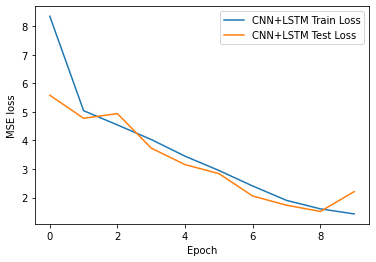

In [53]:
seq_len = len(train_df['seq'][0])
multi_cnnlstm_model = DNA_CNNLSTM_Multi(seq_len)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_cnnlstm_model.parameters(), lr=0.01) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses_cnnlstm, val_losses_cnnlstm = fit(epochs, multi_cnnlstm_model, loss_func, optimizer, train_dl, test_dl)

multi_cnnlstm_data_label = list(zip([train_losses_cnnlstm,val_losses_cnnlstm], ['CNN+LSTM Train Loss','CNN+LSTM Test Loss']))
u.quick_loss_plot(multi_cnnlstm_data_label)

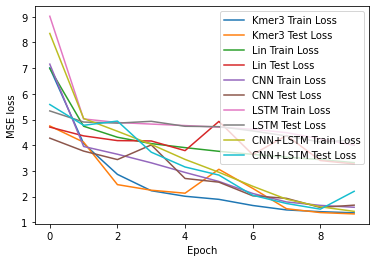

In [54]:
u.quick_loss_plot(
    kmer_lin_data_label + \
    multi_lin_data_label + \
    multi_cnn_data_label + \
    multi_lstm_data_label + \
    multi_cnnlstm_data_label
)

Running Multi_CNNLSTM_8mer


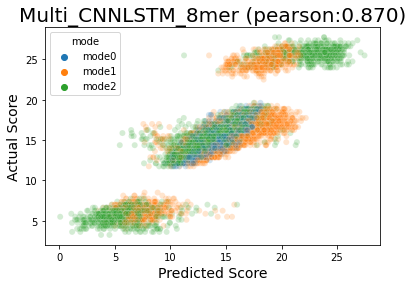

{'Multi_CNNLSTM_8mer': (0.8698115402367805,
              seq   truth       pred   mode
  0      AAAAAACT  18.500  16.085796  mode0
  1      AAAAAACT  18.500  16.100258  mode1
  2      AAAAAACT  18.500  16.330814  mode2
  3      AAAAAAGG  18.500  14.484943  mode0
  4      AAAAAAGG   8.500   8.847115  mode1
  ...         ...     ...        ...    ...
  39319  TTTTTTGG  11.750   8.053122  mode1
  39320  TTTTTTGG  11.750   9.785849  mode2
  39321  TTTTTTTA  12.125  11.190222  mode0
  39322  TTTTTTTA  12.125  12.868361  mode1
  39323  TTTTTTTA  12.125  10.262932  mode2
  
  [39324 rows x 4 columns])}

In [55]:
models = [
#     ("Multi_Linear_8mer",multi_lin_model,DatasetSpec('multi_ohe')),
#     ("Multi_Kmer_8mer",kmer_lin_model,DatasetSpec('multi_kmer',k=3)),
#     ("Multi_CNN_8mer",multi_cnn_model,DatasetSpec('multi_ohe')),
#     ("Multi_LSTM_8mer",multi_lstm_model,DatasetSpec('multi_ohe')),
    ("Multi_CNNLSTM_8mer",multi_cnnlstm_model,DatasetSpec('multi_ohe')),
]

seqs = test_df['seq'].values
task = "8mer_multitask_orderedMotifs"

parity_pred_multi(models, seqs, multi_8mer_oracle,task,alt=True)